In [100]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, cv

Преобразовали данные

In [222]:
df1 = pd.read_csv('21-22.csv', sep=';')
def create_df(df):
    df = df.iloc[:-4]
    df = df[['Wk', 'Day', 'Date', 'Time', 'Home', 'Score', 'Away', 'Referee']]
    df['Wk'] = df['Wk'].astype(int)
    df[['Home_score', 'Away_score']] = df['Score'].str.split('–', expand=True)
    df[['Home_score', 'Away_score']] = df[['Home_score', 'Away_score']].astype(int) 
    df['Month'] = df['Date'].apply(lambda x: x[3:5])
    df['Hours'] = df['Time'].apply(lambda x: x[:2]).astype(int)
    df = df.drop(['Score', 'Date', 'Time'], axis=1)
    df['target'] = np.where(df['Home_score'] > df['Away_score'], 0, 
                            np.where(df['Home_score'] < df['Away_score'], 2, 1))
    # 0 - победа хозяев, 1 - ничья, 2 - победа гостей
    df = df.drop(['Home_score', 'Away_score'], axis=1)
    return df
df1 = create_df(df1)
df1

,Wk,Day,Home,Away,Referee,Month,Hours,target
0,1,Fri,Rostov,Dynamo Mosc,Vladimir Moskalev,07,20,2
1,1,Sat,FC Khimki,Zenit,Evgeny Kukulyak,07,17,2
2,1,Sat,Rubin Kazan,Spartak Moscow,Vladislav Bezborodov,07,20,0
3,1,Sat,Loko Moscow,Arsenal Tula,Igor Panin,07,20,0
4,1,Sun,Ural,Krasnodar,Vasiliy Kazartsev,07,19,2
...,...,...,...,...,...,...,...,...
235,30,Sat,FC Khimki,Spartak Moscow,Sergey Karasev,05,17,0
236,30,Sat,CSKA Moscow,Rostov,Yan Bobrovskiy,05,17,0
237,30,Sat,Dynamo Mosc,Sochi,Vladimir Moskalev,05,17,2
238,30,Sat,Krasnodar,Akhmat Grozny,Pavel Shadykhanov,05,17,1


In [223]:
Total_20_21 = {'Rostov': 9, 'FC Khimki': 8, 'Rubin Kazan': 4, 'Loko Moscow': 3, 'Ural': 12,
       'Samara': None, 'CSKA Moscow': 6, 'Nizhny Novgorod': None, 'Arsenal Tula': 14, 'Ufa':13,
       'Krasnodar':10, 'Akhmat Grozny':11, 'Zenit':1, 'Spartak Moscow':2,
       'Dynamo Mosc':7, 'Sochi':5}
df1['Total_last_year_Home'] = df1['Home'].apply(lambda x: Total_20_21[x])
df1['Total_last_year_Away'] = df1['Away'].apply(lambda x: Total_20_21[x])
df1

,Wk,Day,Home,Away,Referee,Month,Hours,target,Total_last_year_Home,Total_last_year_Away
0,1,Fri,Rostov,Dynamo Mosc,Vladimir Moskalev,07,20,2,9.0,7.0
1,1,Sat,FC Khimki,Zenit,Evgeny Kukulyak,07,17,2,8.0,1.0
2,1,Sat,Rubin Kazan,Spartak Moscow,Vladislav Bezborodov,07,20,0,4.0,2.0
3,1,Sat,Loko Moscow,Arsenal Tula,Igor Panin,07,20,0,3.0,14.0
4,1,Sun,Ural,Krasnodar,Vasiliy Kazartsev,07,19,2,12.0,10.0
...,...,...,...,...,...,...,...,...,...,...
235,30,Sat,FC Khimki,Spartak Moscow,Sergey Karasev,05,17,0,8.0,2.0
236,30,Sat,CSKA Moscow,Rostov,Yan Bobrovskiy,05,17,0,6.0,9.0
237,30,Sat,Dynamo Mosc,Sochi,Vladimir Moskalev,05,17,2,7.0,5.0
238,30,Sat,Krasnodar,Akhmat Grozny,Pavel Shadykhanov,05,17,1,10.0,11.0


In [224]:
df2 = pd.read_csv('22-23.csv', sep=';')
df2 = create_df(df2)
Total_21_22 = {'FC Khimki':13, 'CSKA Moscow':5, 'Orenburg':None, 'Akhmat Grozny':7,
       'Torpedo Moscow':None, 'Loko Moscow':6, 'Dynamo Mosc':3, 'Krasnodar':4,
       'Zenit':1, 'Ural':12, 'Fakel Voronezh':None, 'Sochi':2, 'Nizhny Novgorod':11,
       'Spartak Moscow':10, 'Samara':8, 'Rostov':9}
df2['Total_last_year_Home'] = df2['Home'].apply(lambda x: Total_21_22[x])
df2['Total_last_year_Away'] = df2['Away'].apply(lambda x: Total_21_22[x])
df2

,Wk,Day,Home,Away,Referee,Month,Hours,target,Total_last_year_Home,Total_last_year_Away
0,1,Fri,FC Khimki,Zenit,Evgeny Kukulyak,07,20,1,13.0,1.0
1,1,Sat,CSKA Moscow,Ural,Vitaly Meshkov,07,15,0,5.0,12.0
2,1,Sat,Orenburg,Samara,Pavel Shadykhanov,07,19,2,NaN,8.0
3,1,Sat,Akhmat Grozny,Spartak Moscow,Vladislav Bezborodov,07,20,1,7.0,10.0
4,1,Sun,Torpedo Moscow,Sochi,Sergey Ivanov,07,15,2,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
235,30,Sat,Akhmat Grozny,Krasnodar,Rafael Shafeev,06,17,1,7.0,4.0
236,30,Sat,CSKA Moscow,Rostov,Pavel Kukuyan,06,17,0,5.0,9.0
237,30,Sat,Samara,Spartak Moscow,Aleksey Amelin,06,18,0,8.0,10.0
238,30,Sat,Orenburg,Dynamo Mosc,Sergey Ivanov,06,19,0,NaN,3.0


In [225]:
df = pd.concat([df1, df2], axis=0)
df

,Wk,Day,Home,Away,Referee,Month,Hours,target,Total_last_year_Home,Total_last_year_Away
0,1,Fri,Rostov,Dynamo Mosc,Vladimir Moskalev,07,20,2,9.0,7.0
1,1,Sat,FC Khimki,Zenit,Evgeny Kukulyak,07,17,2,8.0,1.0
2,1,Sat,Rubin Kazan,Spartak Moscow,Vladislav Bezborodov,07,20,0,4.0,2.0
3,1,Sat,Loko Moscow,Arsenal Tula,Igor Panin,07,20,0,3.0,14.0
4,1,Sun,Ural,Krasnodar,Vasiliy Kazartsev,07,19,2,12.0,10.0
...,...,...,...,...,...,...,...,...,...,...
235,30,Sat,Akhmat Grozny,Krasnodar,Rafael Shafeev,06,17,1,7.0,4.0
236,30,Sat,CSKA Moscow,Rostov,Pavel Kukuyan,06,17,0,5.0,9.0
237,30,Sat,Samara,Spartak Moscow,Aleksey Amelin,06,18,0,8.0,10.0
238,30,Sat,Orenburg,Dynamo Mosc,Sergey Ivanov,06,19,0,NaN,3.0


In [226]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338 entries, 0 to 239
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wk                    338 non-null    int64  
 1   Day                   338 non-null    object 
 2   Home                  338 non-null    object 
 3   Away                  338 non-null    object 
 4   Referee               338 non-null    object 
 5   Month                 338 non-null    object 
 6   Hours                 338 non-null    int64  
 7   target                338 non-null    int64  
 8   Total_last_year_Home  338 non-null    float64
 9   Total_last_year_Away  338 non-null    float64
dtypes: float64(2), int64(3), object(5)
memory usage: 29.0+ KB


In [227]:
cat_features = ['Day', 'Home', 'Away', 'Referee', 'Month']
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'], test_size=0.2)

In [228]:
train = Pool(data=X_train,
             label=y_train,
             cat_features=cat_features)
test = Pool(data=X_test,
             label=y_test,
             cat_features=cat_features)

In [229]:
iter = 500
params = {
    "iterations":iter,
    "depth": 3,
    "custom_loss": "Accuracy",
    "learning_rate": 0.05,
    "loss_function": "MultiClass",
    "verbose": False
}
scores = cv(train,
            params,
           fold_count=5)
scores

Training on fold [0/5]

bestTest = 0.9564694436
bestIteration = 287

Training on fold [1/5]

bestTest = 1.045307944
bestIteration = 56

Training on fold [2/5]

bestTest = 1.010567637
bestIteration = 118

Training on fold [3/5]

bestTest = 0.9497786061
bestIteration = 374

Training on fold [4/5]

bestTest = 1.034556643
bestIteration = 111



,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std
0,0,1.094394,0.001309,1.091760,0.001896,0.485596,0.030151,0.495293,0.024769
1,1,1.090264,0.003343,1.085155,0.002103,0.493288,0.043032,0.509230,0.021910
2,2,1.087132,0.003730,1.079232,0.001427,0.467559,0.062741,0.514880,0.017342
3,3,1.083228,0.003494,1.074109,0.002870,0.482032,0.034932,0.525044,0.010267
4,4,1.080180,0.003914,1.069296,0.003078,0.481757,0.047572,0.531448,0.009882
...,...,...,...,...,...,...,...,...,...
495,495,1.041428,0.082377,0.548781,0.015516,0.496497,0.060585,0.880488,0.018234
496,496,1.041739,0.082688,0.548472,0.015445,0.496497,0.060585,0.880488,0.018234
497,497,1.042104,0.082743,0.547973,0.015412,0.492861,0.067926,0.881418,0.017351
498,498,1.042108,0.082473,0.547508,0.015465,0.492861,0.067926,0.882335,0.019153


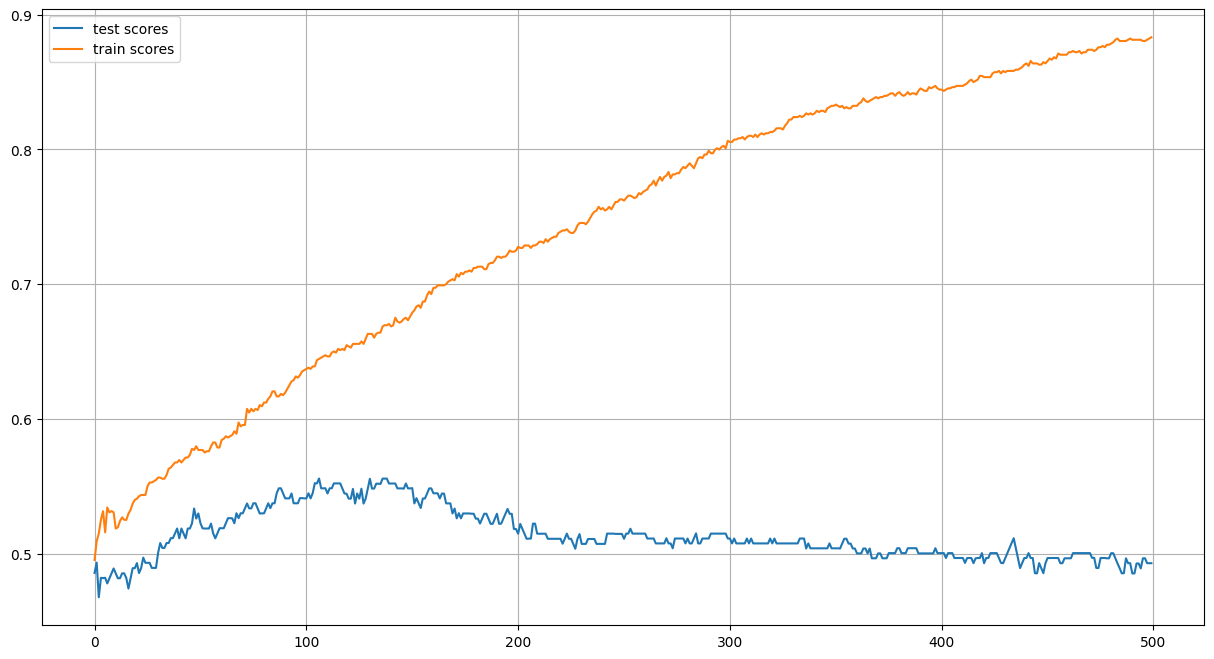

In [230]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(iter), scores['test-Accuracy-mean'].values, label='test scores')
plt.plot(np.arange(iter), scores['train-Accuracy-mean'].values, label='train scores')
plt.legend()
plt.grid(True)
plt.show()

In [231]:
cb = CatBoostClassifier(iterations=70, depth=3, custom_loss="Accuracy",
                        learning_rate=0.05, loss_function="MultiClass",
                        verbose=False)
cb.fit(train)


In [232]:
data = pd.read_csv('23-24.csv', sep=';')
data = create_df(data)
m1 = data.iloc[6]       # Берем матч Ростов-Факел
m1['Total_last_year_Home'] = 4
m1['Total_last_year_Away'] = 14
m1

Wk                                      1
Day                                   Sun
Home                               Rostov
Away                       Fakel Voronezh
Referee                 Pavel Shadykhanov
Month                                  07
Hours                                  20
target                                  0
Total_last_year_Home                    4
Total_last_year_Away                   14
Name: 6, dtype: object

In [233]:
print(cb.predict(m1)[0], cb.predict_proba(m1)) # Он предсказал победу Ростова в матче Ростов-Факел
                                  # Реальный счет 2-1 в пользу Ростова

0 [0.49037791 0.20256413 0.30705796]


In [202]:
data

,Wk,Day,Home,Away,Referee,Month,Hours,target
0,1,Fri,Dynamo Mosc,Krasnodar,Kirill Levnikov,07,19,2
1,1,Sat,Ural,CSKA Moscow,Aleksey Amelin,07,15,1
2,1,Sat,Nizhny Novgorod,Zenit,Sergey Ivanov,07,15,2
3,1,Sat,Loko Moscow,Rubin Kazan,Vladislav Bezborodov,07,17,0
4,1,Sat,Akhmat Grozny,Samara,Sergey Karasev,07,20,2
5,1,Sun,Spartak Moscow,Orenburg,Artem Chistyakov,07,17,1
6,1,Sun,Rostov,Fakel Voronezh,Pavel Shadykhanov,07,20,1
7,1,Sun,Sochi,FC Baltika Kaliningrad,Rafael Shafeev,07,21,1
8,2,Sat,Samara,Dynamo Mosc,Artem Lyubimov,07,16,0
9,2,Sat,Ural,Nizhny Novgorod,Artem Chistyakov,07,19,0


In [234]:
m2 = data.iloc[10]   # Ростов-Зенит
m2['Total_last_year_Home'] = 4
m2['Total_last_year_Away'] = 1
m2

Wk                                    2
Day                                 Sat
Home                             Rostov
Away                              Zenit
Referee                 Evgeny Kukulyak
Month                                07
Hours                                20
target                                1
Total_last_year_Home                  4
Total_last_year_Away                  1
Name: 10, dtype: object

In [235]:
print(cb.predict(m2)[0], cb.predict_proba(m2))  # Он предсказал победу Ростова 
                                                # чуть увереннее, чем победу Зенита, реальный счет 1-1

0 [0.39269843 0.25084206 0.35645951]


In [236]:
m3 = data.iloc[20]    # ЦСКА - Локомотив
m3['Total_last_year_Home'] = 2
m3['Total_last_year_Away'] = 8
m3

Wk                                    3
Day                                 Sat
Home                        CSKA Moscow
Away                        Loko Moscow
Referee                 Kirill Levnikov
Month                                08
Hours                                20
target                                0
Total_last_year_Home                  2
Total_last_year_Away                  8
Name: 20, dtype: object

In [237]:
print(cb.predict(m3)[0], cb.predict_proba(m3))  # С отрывом предсказал победу ЦСКА,
                                                # реальный счет 4-1 в пользу ЦСКА

0 [0.50666461 0.21919387 0.27414153]


In [240]:
cb.get_feature_importance(test)

array([ 7.30039671,  2.90243957, 18.24084373, 15.3175973 ,  0.        ,
        1.31286417,  7.17249584, 25.6464858 , 22.10687688])

In [241]:
X_train.columns

Index(['Wk', 'Day', 'Home', 'Away', 'Referee', 'Month', 'Hours',
       'Total_last_year_Home', 'Total_last_year_Away'],
      dtype='object')